# Chapter 10 Predicting Continuous Traget Variables with Regression Analysis

- Exploring and visualizing datasets
- Looking at different approaches to implement linear regression models
- Training regression models and diagnosing common problems
- Fitting regression models to nonlinear data

## Exploring the housing dataset

In [139]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


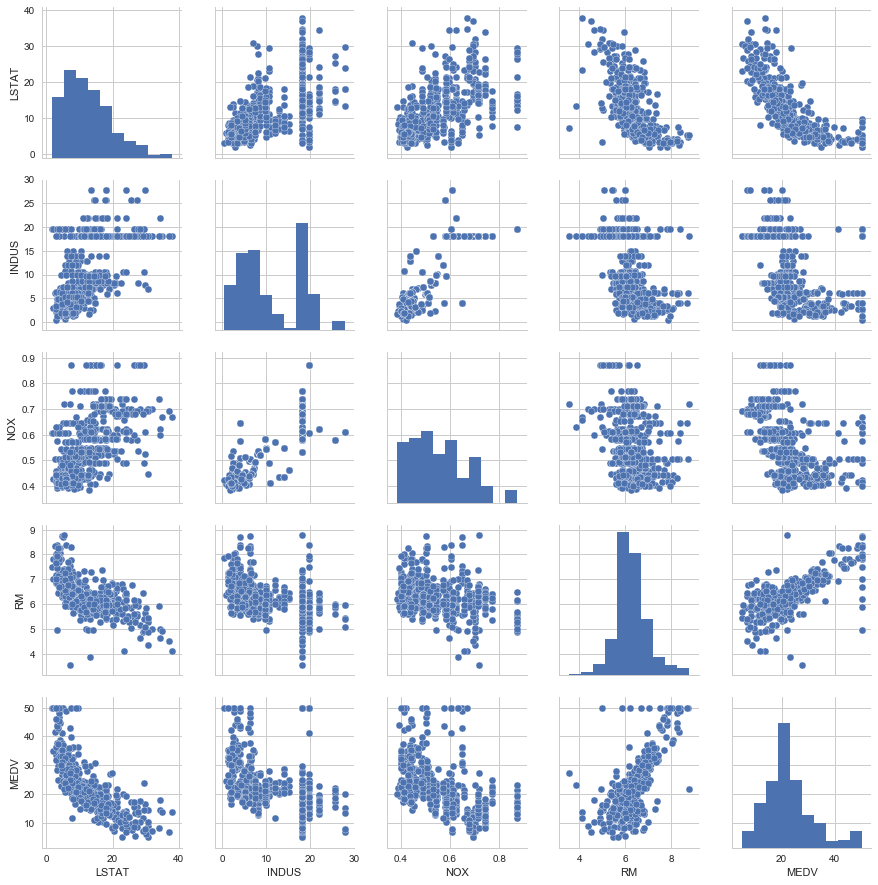

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5)
plt.show()

#### Plotting the Pearson's Correlation Coefficient (r) matrix

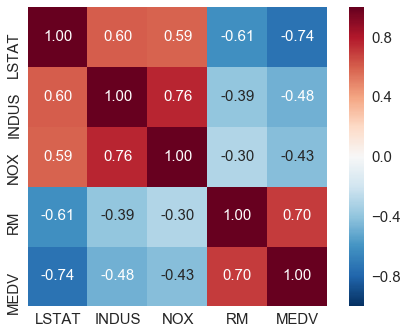

In [141]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)
plt.show()

In [142]:
sns.reset_orig()
%matplotlib inline

## Implementing an ordinary least squares linear regression model

### Solving regression for regression parameters with gradien descent

In [143]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [144]:
X = df[['RM']].values
y = df['MEDV'].values

In [145]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [146]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

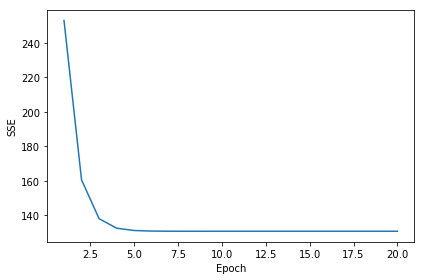

In [147]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

In [148]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='lightblue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)    
    return

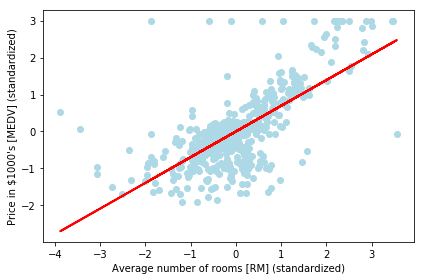

In [149]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()
# plt.savefig('./figures/gradient_fit.png', dpi=300)
plt.show()

In [150]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


In [151]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))
print(num_rooms_std, price_std)

Price in $1000's: 10.840
[[-1.83016553]] [-1.27262285]


### Estimating the coefficient of a regression model via scikit-learn

In [152]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


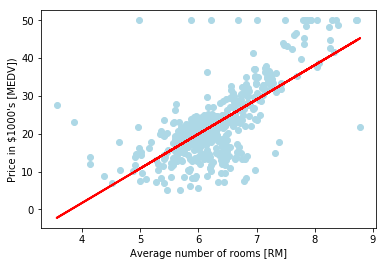

In [153]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV])')
plt.show()

## Fitting a robust regression model using RANSAC

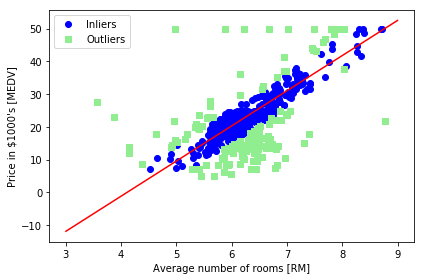

In [154]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_loss', 
                         residual_threshold=5.0, 
                         random_state=0)

ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/ransac_fit.png', dpi=300)
plt.show()

In [155]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


## Evaluating the performance of linear regression models

In [156]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [157]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

#### Method 1: Use the residule plot to evaluate the model's performance

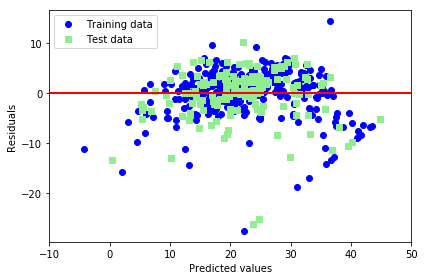

In [158]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

#### Method 2: Use the Mean Squared Error (MSE) to evaluate the model's performance

In [159]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


## Turning a linear regression model into a curve - polynomial regression

In [176]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [177]:
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

In [178]:
print(X_quad)

[[  1.00000000e+00   2.58000000e+02   6.65640000e+04]
 [  1.00000000e+00   2.70000000e+02   7.29000000e+04]
 [  1.00000000e+00   2.94000000e+02   8.64360000e+04]
 [  1.00000000e+00   3.20000000e+02   1.02400000e+05]
 [  1.00000000e+00   3.42000000e+02   1.16964000e+05]
 [  1.00000000e+00   3.68000000e+02   1.35424000e+05]
 [  1.00000000e+00   3.96000000e+02   1.56816000e+05]
 [  1.00000000e+00   4.46000000e+02   1.98916000e+05]
 [  1.00000000e+00   4.80000000e+02   2.30400000e+05]
 [  1.00000000e+00   5.86000000e+02   3.43396000e+05]]


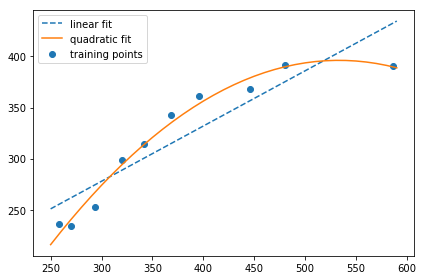

In [181]:
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/poly_example.png', dpi=300)
plt.show()

In [182]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [165]:
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


### Modeling nonlinear relationships in the Housing Dataset

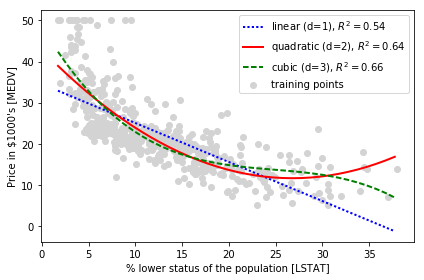

In [166]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('./figures/polyhouse_example.png', dpi=300)
plt.show()

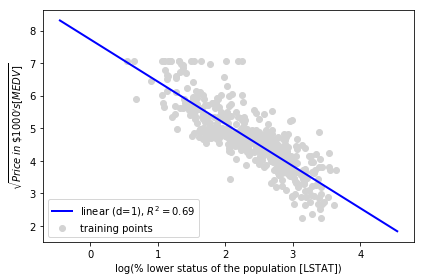

In [167]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
# plt.savefig('./figures/transform_example.png', dpi=300)
plt.show()

## Dealing with nonlinear relationships using random forests

### Decision tree regression

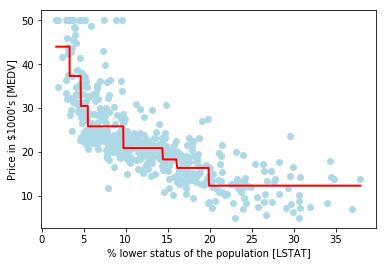

In [168]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
# plt.savefig('./figures/tree_regression.png', dpi=300)
plt.show()

### Random forest regression (more robust than decision tree)

In [169]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [170]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


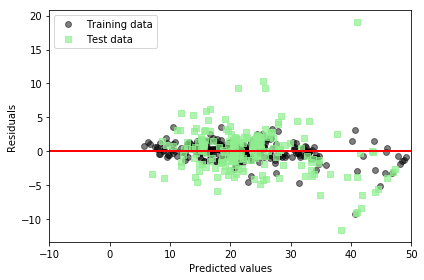

In [171]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='black', 
            marker='o', 
            s=35,
            alpha=0.5,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='lightgreen', 
            marker='s', 
            s=35,
            alpha=0.7,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()